In [31]:
%pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.2/265.2 MB 5.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.3-py2.py3-none-any.whl size=265293969 sha256=99c49051e9c6ff7961ad72c728054efe56c933cc5e2eae746b45b326b63b12ff
  Stored in directory: /Users/pragneshanekal/Library/Caches/pip/wheels/a4/b0/bc/79490e55ff2118dbc0329354b703437e639bf6d40bb5c99768
Successfully built h2o
Note: you may need to restart the kernel to use updated packages.


In [64]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
import h2o
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

### Perform Sentiment Analysis on transcripts

- Obtain sentiment for each session for each dialogue of the client.
- Calculate weighted average of sentiment scores for each session, latest session gets highest weight and so on.

In [65]:
# Load the CSV file
df = pd.read_csv('transcript_notes.csv')

# Filter rows where speaker is 'client'
client_texts = df[df['Speaker'] == 'Client']['Text']

# Initialize NLTK's sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Analyze sentiment of each text
sentiments = client_texts.apply(lambda text: sia.polarity_scores(text))

# Convert the Series of dictionaries into a DataFrame
sentiments_df = pd.DataFrame(sentiments.tolist())

# Reset index to merge with client_texts on index
client_texts_df = client_texts.reset_index(drop=True)

# Combine the text and its sentiment scores
combined_df = pd.concat([client_texts_df, sentiments_df], axis=1)

# Rename the 'text' column (if necessary)
combined_df.rename(columns={'text': 'client_text'}, inplace=True)

# Export to a new CSV file
output_file_path = 'client_sentiment_scores.csv'
combined_df.to_csv(output_file_path, index=False)

print(f"DataFrame exported to {output_file_path}")

DataFrame exported to client_sentiment_scores.csv


In [66]:
# Filter rows where Speaker is 'Client'
client_texts = df[df['Speaker'] == 'Client'].copy()

# Define a function to calculate sentiment scores
def calculate_sentiment(text):
    return sia.polarity_scores(text)['compound']  # Using compound score for overall sentiment

# Apply sentiment analysis on the 'Text' column
client_texts['Sentiment_Score'] = client_texts['Text'].apply(calculate_sentiment)

# Group by 'Session' and calculate the average sentiment score for each session
session_sentiment = client_texts.groupby('Session')['Sentiment_Score'].mean().reset_index()

# Rename columns for clarity
session_sentiment.rename(columns={'Sentiment_Score': 'Average_Sentiment_Score'}, inplace=True)

# Export the DataFrame to a new CSV file
output_file_path = 'session_average_sentiment.csv'
session_sentiment.to_csv(output_file_path, index=False)

output_file_path

'session_average_sentiment.csv'

### Sentiment Analysis on Session Notes by Therapist

- Similar process of weighting the sentiments and calculating overall numerical average sentiment
  by including the sentiment scores from transcripts.

In [67]:
# Load the data
data = pd.read_csv('therapy_data_final.csv')

# Initialize NLTK's sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment score
def calculate_sentiment(text):
    if pd.isnull(text):  # Check for NaN values and return neutral sentiment for them
        return 0
    return sia.polarity_scores(text)['compound']

# List of columns to perform sentiment analysis on
columns_to_analyze = [
    "Reason for Referral", "Presentation", "Speech", "Mood and Affect",
    "Thought Process", "Insight and Judgment", "Clinical Impressions and Diagnostic Considerations"
]

# Apply sentiment analysis on each specified column
for column in columns_to_analyze:
    data[column + ' Sentiment'] = data[column].apply(calculate_sentiment)

# Save to a new CSV file
data.to_csv('therapy_data_sentiments.csv', index=False)

In [69]:
# Load the CSV file
session_average_sentiment_df = pd.read_csv('session_average_sentiment.csv')

# Determine the total number of sessions
num_sessions = session_average_sentiment_df['Session'].max()

# Assign weights based on session number (more recent sessions get higher weights)
# Assuming session numbers are sequential and start from 1
session_average_sentiment_df['Weight'] = session_average_sentiment_df['Session'].apply(lambda x: x)

# Calculate the weighted sentiment score
session_average_sentiment_df['Weighted_Sentiment'] = session_average_sentiment_df['Average_Sentiment_Score'] * session_average_sentiment_df['Weight']

# Write the updated dataframe to a new CSV file
output_path = 'weighted_session_average_sentiment.csv'
session_average_sentiment_df.to_csv(output_path, index=False)

output_path

'weighted_session_average_sentiment.csv'

In [71]:
# Load the weighted session average sentiment CSV
weighted_session_average_sentiment_df = pd.read_csv('weighted_session_average_sentiment.csv')

# Reload the therapy data sentiments CSV to ensure it's in the current context
therapy_data_sentiments_df = pd.read_csv('/Users/pragneshanekal/Desktop/therapy_data_sentiments.csv')

# Display the first few rows of both DataFrames to identify the key for merging
weighted_session_average_sentiment_df.head(), therapy_data_sentiments_df.head()

# Merge the DataFrames on the session number
# Renaming the 'Session' column in weighted_session_average_sentiment_df to match 'Session Number' in therapy_data_sentiments_df for a clean merge
weighted_session_average_sentiment_df.rename(columns={'Session': 'Session Number'}, inplace=True)

# Performing the merge
merged_df = pd.merge(therapy_data_sentiments_df, weighted_session_average_sentiment_df, on='Session Number', how='inner')

# Save the merged DataFrame to a new CSV file
merged_output_path = 'merged_therapy_data.csv'
merged_df.to_csv(merged_output_path, index=False)

merged_output_path

'merged_therapy_data.csv'

In [72]:
# Read the dataset
data_path = 'merged_therapy_data.csv'
data = pd.read_csv(data_path)

# Define a function to calculate the weighted sentiment score
def calculate_corrected_weighted_sentiment(sentiment_scores, session_number, max_session_number):
    weight = session_number  # Assign weights from 1 for the oldest session to 10 for the latest
    weighted_sentiment_scores = sentiment_scores * weight
    return weighted_sentiment_scores

# List of sentiment columns to calculate weighted scores for
sentiment_columns = [
    'Reason for Referral Sentiment',
    'Presentation Sentiment',
    'Speech Sentiment',
    'Mood and Affect Sentiment',
    'Thought Process Sentiment',
    'Insight and Judgment Sentiment',
    'Clinical Impressions and Diagnostic Considerations Sentiment'
]

# Get the maximum session number to set the correct weights
max_session_number = data['Session Number'].max()

# Calculate the weighted sentiment score for each sentiment column with corrected weights
for column in sentiment_columns:
    weighted_column_name = f'Weighted {column}'
    data[weighted_column_name] = calculate_corrected_weighted_sentiment(
        data[column],
        data['Session Number'],
        max_session_number
    )

# Save the updated dataframe to a new CSV file without the original sentiment columns
final_output_file_path = 'final_weighted_sentiment_scores.csv'
data.to_csv(final_output_file_path, index=False)

# Output the path to the final CSV file
final_output_file_path


'final_weighted_sentiment_scores.csv'

In [73]:
# Read the final weighted sentiment scores CSV file
final_data_path = 'final_weighted_sentiment_scores.csv'
final_data = pd.read_csv(final_data_path)

# Extract columns that contain the weighted sentiment scores
weighted_sentiment_columns = [col for col in final_data.columns if col.startswith('Weighted')]

# Calculate the average sentiment score for each session
final_data['Average Session Sentiment'] = final_data[weighted_sentiment_columns].mean(axis=1)

# Save the updated dataframe with the average sentiment score to a new CSV file
average_sentiment_file_path = 'average_session_sentiment_scores.csv'
final_data.to_csv(average_sentiment_file_path, index=False)

average_sentiment_file_path

'average_session_sentiment_scores.csv'

### AutoML to Perform Predictive Modeling

- Use all data available to predict future sentiment state of the client (assessment scores, session notes, and transcript)

In [74]:
h2o.init()

therapy_data = h2o.import_file('average_session_sentiment_scores.csv')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 30 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,2 months and 7 days
H2O_cluster_name:,H2O_from_python_pragneshanekal_uhjurj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.261 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [39]:
# Convert categorical columns to factors
categorical_columns = ['Reason for Referral', 
                       'Presentation', 'Speech', 'Mood and Affect',
                       'Thought Process', 'Insight and Judgment',
                       'Clinical Impressions and Diagnostic Considerations', 'Short-Term Goals',
                      'Long-Term Goals', 'Planned Interventions', 'Homework Assignments']
for col in categorical_columns:
    therapy_data[col] = therapy_data[col].asfactor()

# Verify the conversion
therapy_data.types

{'Name': 'enum',
 'Age': 'int',
 'Gender': 'enum',
 'Date of Session': 'time',
 'Session Number': 'int',
 'Therapist': 'enum',
 'Reason for Referral': 'enum',
 'Presentation': 'enum',
 'Speech': 'enum',
 'Mood and Affect': 'enum',
 'Thought Process': 'enum',
 'Insight and Judgment': 'enum',
 'BDI Score': 'int',
 'GAD-7 Score': 'int',
 'GAF Score': 'int',
 'Clinical Impressions and Diagnostic Considerations': 'enum',
 'Short-Term Goals': 'enum',
 'Long-Term Goals': 'enum',
 'Planned Interventions': 'enum',
 'Homework Assignments': 'enum',
 'Follow-Up': 'enum',
 'Average_Sentiment_Score': 'real',
 'Weight': 'int',
 'Weighted_Sentiment': 'real',
 'Weighted Reason for Referral Sentiment': 'real',
 'Weighted Presentation Sentiment': 'real',
 'Weighted Speech Sentiment': 'real',
 'Weighted Mood and Affect Sentiment': 'real',
 'Weighted Thought Process Sentiment': 'real',
 'Weighted Insight and Judgment Sentiment': 'real',
 'Weighted Clinical Impressions and Diagnostic Considerations Sentimen

In [33]:
therapy_data.types

{'Name': 'enum',
 'Age': 'int',
 'Gender': 'enum',
 'Date of Session': 'time',
 'Session Number': 'int',
 'Therapist': 'enum',
 'Reason for Referral': 'string',
 'Presentation': 'string',
 'Speech': 'string',
 'Mood and Affect': 'string',
 'Thought Process': 'string',
 'Insight and Judgment': 'string',
 'BDI Score': 'int',
 'GAD-7 Score': 'int',
 'GAF Score': 'int',
 'Clinical Impressions and Diagnostic Considerations': 'string',
 'Short-Term Goals': 'string',
 'Long-Term Goals': 'string',
 'Planned Interventions': 'string',
 'Homework Assignments': 'string',
 'Follow-Up': 'enum',
 'Average_Sentiment_Score': 'real',
 'Weight': 'int',
 'Weighted_Sentiment': 'real',
 'Weighted Reason for Referral Sentiment': 'real',
 'Weighted Presentation Sentiment': 'real',
 'Weighted Speech Sentiment': 'real',
 'Weighted Mood and Affect Sentiment': 'real',
 'Weighted Thought Process Sentiment': 'real',
 'Weighted Insight and Judgment Sentiment': 'real',
 'Weighted Clinical Impressions and Diagnostic C

In [41]:
response = "Average Session Sentiment"
predictors = list(therapy_data.columns)
predictors.remove('Average Session Sentiment')

In [42]:
aml = H2OAutoML(max_runtime_secs=60, seed=1, nfolds = 5)

In [43]:
aml.train(x=predictors, y=response, training_frame=therapy_data)

AutoML progress: |
18:45:23.151: AutoML: XGBoost is not available; skipping it.
18:45:23.154: _train param, Dropping bad and constant columns: [Gender, Therapist, Age, Name]
18:45:23.277: _train param, Dropping bad and constant columns: [Gender, Therapist, Age, Name]
18:45:23.277: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 10.0.
18:45:23.278: _train param, Dropping bad and constant columns: [Gender, Therapist, Age, Name]


18:45:23.435: _train param, Dropping bad and constant columns: [Gender, Therapist, Age, Name]
18:45:23.435: _min_rows param, The dataset size is too small to split for min_rows=10.0: must have at least 20.0 (weighted) rows, but have only 10.0.
18:45:23.435: _train param, Dropping bad and constant columns: [Gender, Therapist, Age, Name]
18:45:23.435: _min_rows param, The dataset size is too small to split for min_rows=10.0: must have at least 20.0 (weighted) rows, but have only 10

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_3_20240227_184523_model_306


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    46                 46                          7361                   3            6            5.04348       5             10            8.08696

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.0005043041515708626
RMSE: 0.022456717292847202
MAE: 0.015537620708346366
RMSLE: NaN
Mean Residual Deviance: 0.0005043041515708626

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.8277657211992995
RMSE: 0.9098163117900775
MAE: 0.7268801719263862
RMSLE: NaN
Mean Residual Deviance: 0.8277657211992995

Cross-Validation Metrics Summary: 
                        mean      sd        cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  --------  ------------  ------------  ------------  ------------  ------------
mae                     0.739579  0.499433  0.556093      0.204602      0.730315      1.55786       0.649026
mean_residual_deviance  0.842589  0.935435  0.335917      0.0593389     0.790701      2.44275       0.584237
mse                     0.842589  0.935435  0.335917      0.0593389     0.790701      2.44275       0.584237
r2                      -205.775  430.901   -975.333      0.787698      0.849204      -56.0649      0.883728
residual_deviance       0.842589  0.935435  0.335917      0.0593389     0.790701      2.44275       0.584237
rmse                    0.807936  0.487121  0.579584      0.243596      0.889214      1.56293       0.764354
rmsle                   0.54067   0.376762  1.08139       0.25993       0.308561      nan           0.512796

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2024-02-27 18:45:30  6.656 sec   0                  2.00576          1.51213         4.02309
    2024-02-27 18:45:30  6.660 sec   5                  1.18005          0.891335        1.39251
    2024-02-27 18:45:30  6.663 sec   10                 0.700238         0.52907         0.490333
    2024-02-27 18:45:30  6.667 sec   15                 0.421383         0.320291        0.177564
    2024-02-27 18:45:30  6.670 sec   20                 0.252952         0.189577        0.0639848
    2024-02-27 18:45:30  6.674 sec   25                 0.157441         0.117141        0.0247877
    2024-02-27 18:45:30  6.677 sec   30                 0.0951121        0.0698532       0.00904631
    2024-02-27 18:45:30  6.681 sec   35                 0.0604704        0.0440539       0.00365667
    2024-02-27 18:45:30  6.685 sec   40                 0.0367694        0.0259812       0.00135199
    2024-02-27 18:45:30  6.688 sec   45                 0.0239324        0.0166699       0.00057276
    2024-02-27 18:45:30  6.689 sec   46                 0.0224567        0.0155376       0.000504304

Variable Importances: 
variable                                                               relative_importance    scaled_importance      percentage
---------------------------------------------------------------------  ---------------------  ---------------------  ----------------------
Date of Session                                                        56.72397232055664      1.0                    0.2736760924478298
Follow-Up                                                              49.02356719970703      0.8642477808617962     0.2365239555729647
Long-Term Goals                                                        34.

In [44]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_3_20240227_184523_model_306,0.909816,0.827766,0.72688,nan,0.827766
DeepLearning_grid_2_AutoML_3_20240227_184523_model_5,0.941248,0.885949,0.733345,nan,0.885949
DeepLearning_grid_3_AutoML_3_20240227_184523_model_5,0.95268,0.9076,0.78312,nan,0.9076
GBM_grid_1_AutoML_3_20240227_184523_model_47,0.954948,0.911926,0.800307,nan,0.911926
GBM_grid_1_AutoML_3_20240227_184523_model_524,0.959507,0.920654,0.751742,nan,0.920654
DeepLearning_grid_3_AutoML_3_20240227_184523_model_3,0.967175,0.935428,0.717969,nan,0.935428
GBM_grid_1_AutoML_3_20240227_184523_model_867,0.98785,0.975847,0.772637,nan,0.975847
GLM_1_AutoML_3_20240227_184523,1.00031,1.00063,0.784692,nan,1.00063
GBM_grid_1_AutoML_3_20240227_184523_model_1041,1.00215,1.0043,0.810351,nan,1.0043
GBM_grid_1_AutoML_3_20240227_184523_model_21,1.0142,1.02859,0.756137,nan,1.02859


### Plot Visuals to Showcase to Therapist

Plot the following visuals:
- Moving average of overall sentiment scores to analyze trend over sessions
- Change in assessment scores over sessions
- Change in sentiment scores of the indivudal session notes made by therapist over sessions

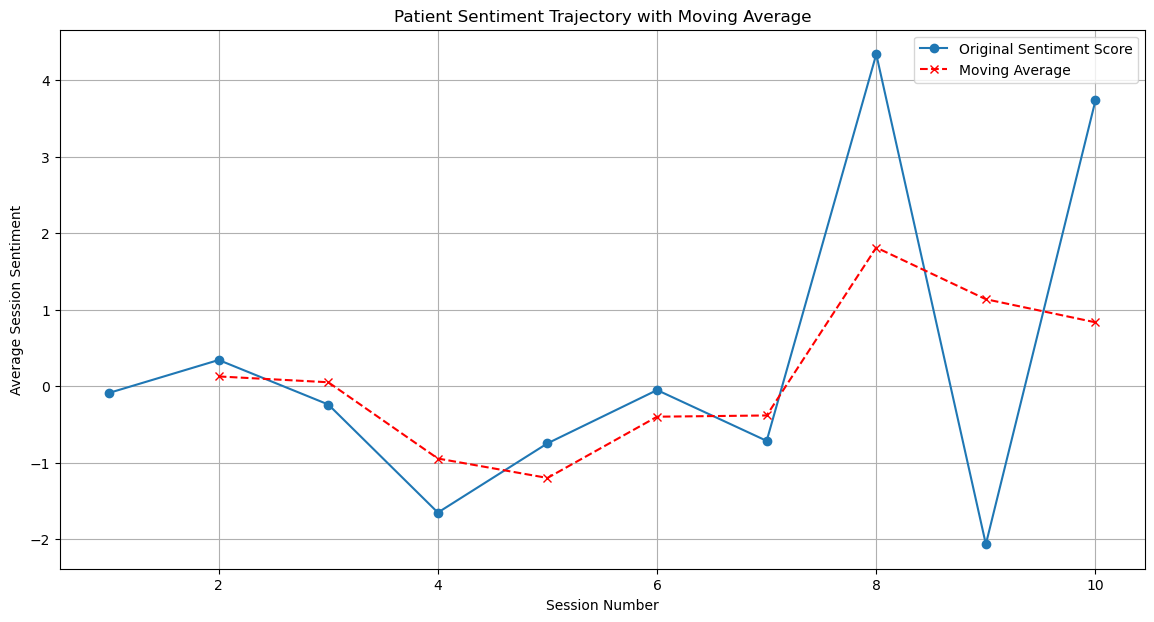

In [75]:
# Now that we've confirmed the correct column name, let's calculate the moving averages again and plot the graph.
df = pd.read_csv('average_session_sentiment_scores.csv')

# Calculate the moving average with a window of 2 for smoothing
df['Moving_Average'] = df['Average Session Sentiment'].rolling(window=2).mean()

# Plot the original sentiment scores and the moving average
plt.figure(figsize=(14, 7))
plt.plot(df['Session Number'], df['Average Session Sentiment'], marker='o', label='Original Sentiment Score')
plt.plot(df['Session Number'], df['Moving_Average'], marker='x', linestyle='--', color='r', label='Moving Average')
plt.title('Patient Sentiment Trajectory with Moving Average')
plt.xlabel('Session Number')
plt.ylabel('Average Session Sentiment')
plt.legend()
plt.grid(True)
plt.show()

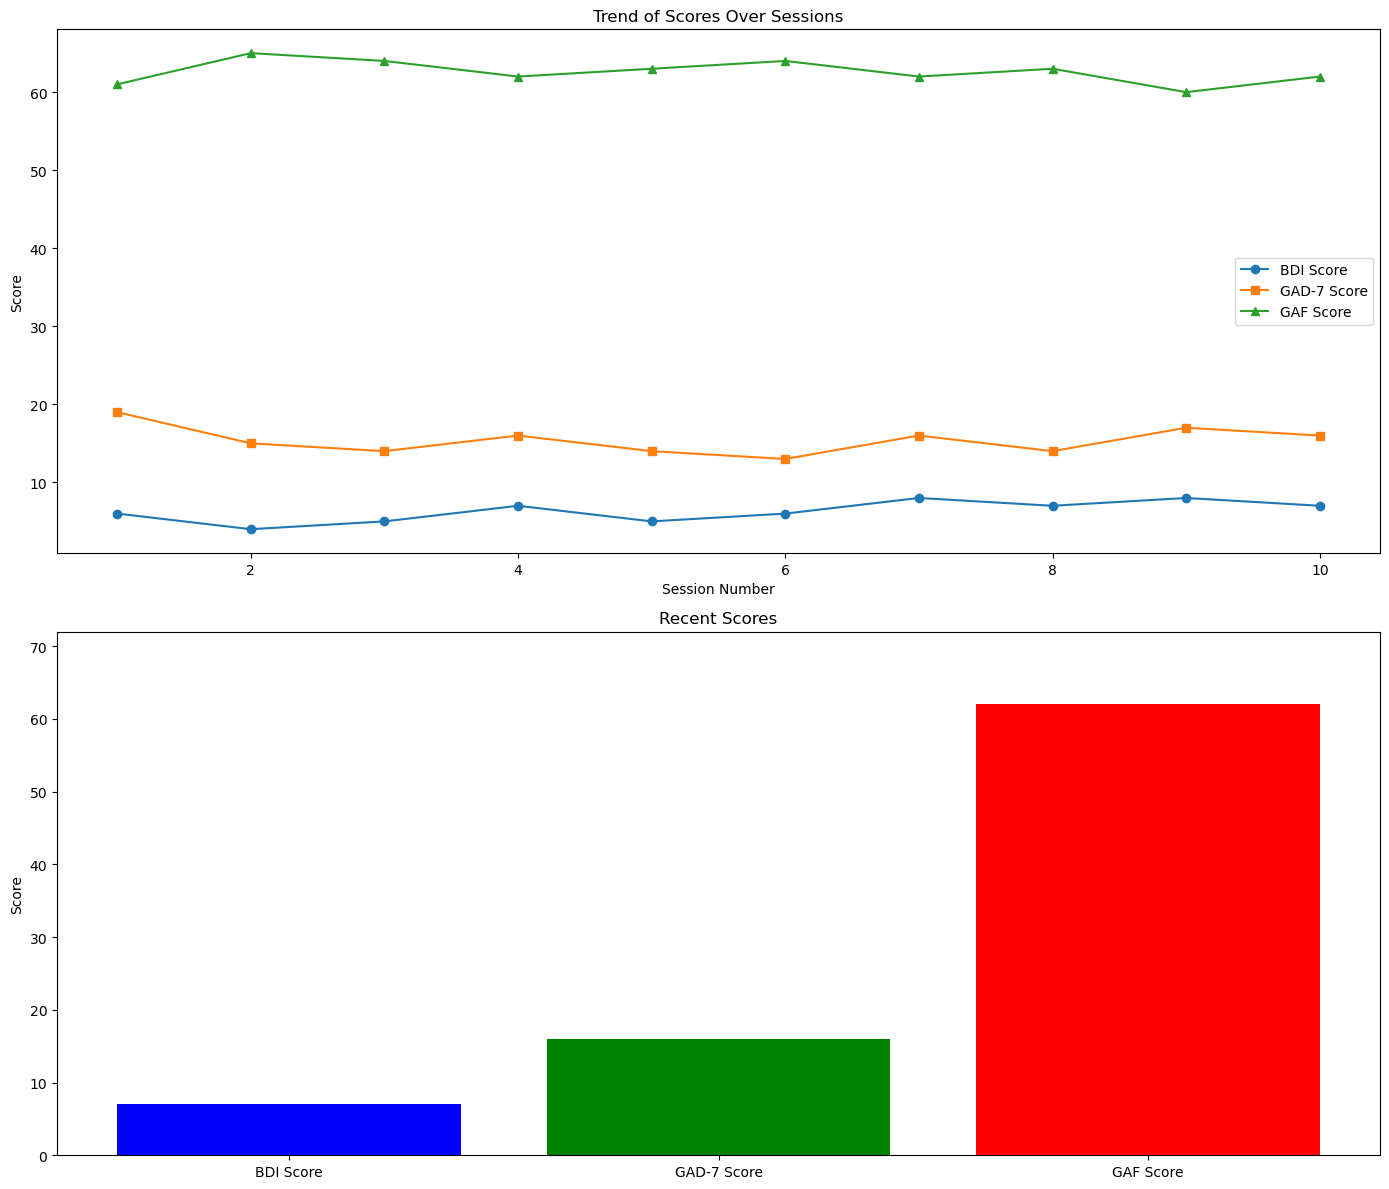

In [56]:
df = pd.read_csv('therapy_data_final.csv')

# Setting up the figure and axes for the plots
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Trend plots
ax[0].plot(df['Session Number'], df['BDI Score'], marker='o', linestyle='-', label='BDI Score')
ax[0].plot(df['Session Number'], df['GAD-7 Score'], marker='s', linestyle='-', label='GAD-7 Score')
ax[0].plot(df['Session Number'], df['GAF Score'], marker='^', linestyle='-', label='GAF Score')

ax[0].set_title('Trend of Scores Over Sessions')
ax[0].set_xlabel('Session Number')
ax[0].set_ylabel('Score')
ax[0].legend()

# Recent scores bar plot
recent_scores = df.iloc[-1][['BDI Score', 'GAD-7 Score', 'GAF Score']]
ax[1].bar(recent_scores.index, recent_scores.values, color=['blue', 'green', 'red'])

ax[1].set_title('Recent Scores')
ax[1].set_ylabel('Score')
ax[1].set_ylim(0, max(recent_scores.values) + 10)  # Setting y-limit to make the plot clearer

plt.tight_layout()
plt.show()

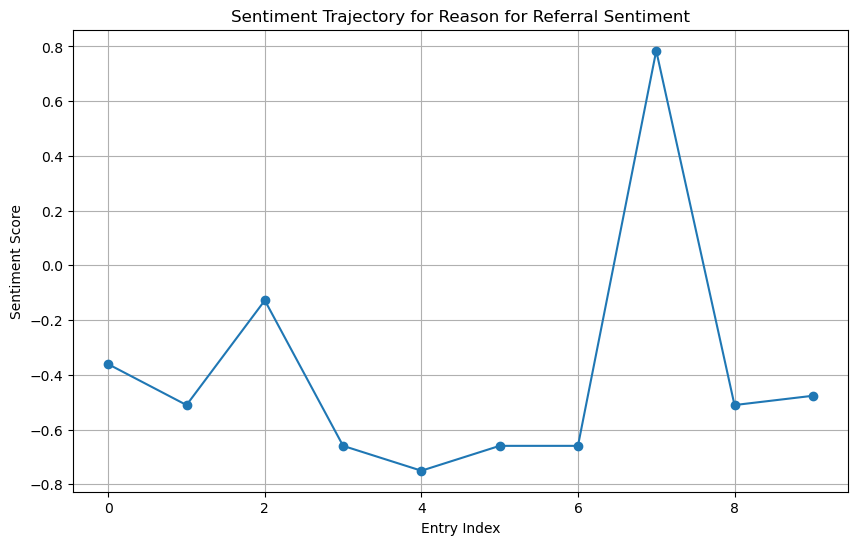

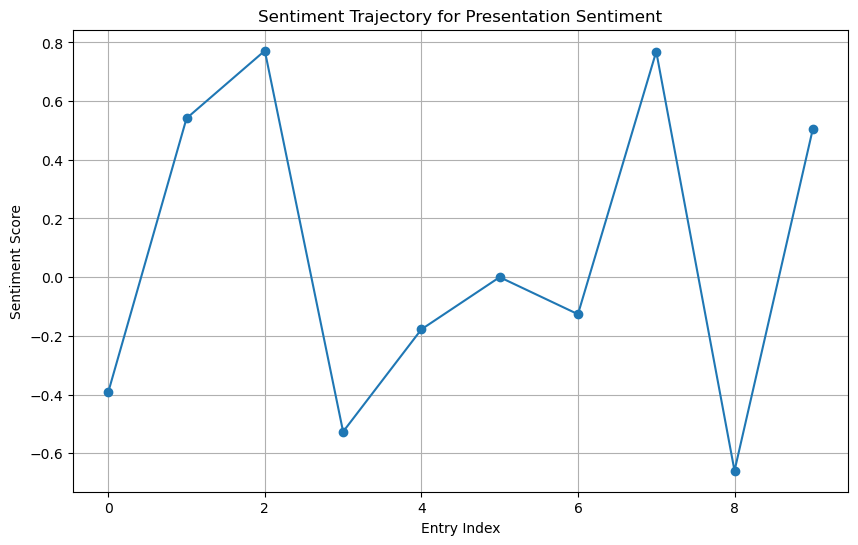

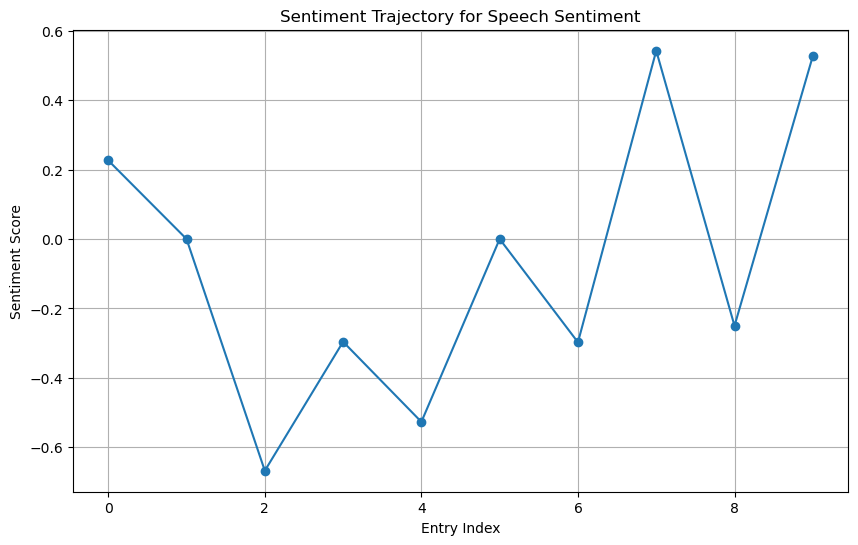

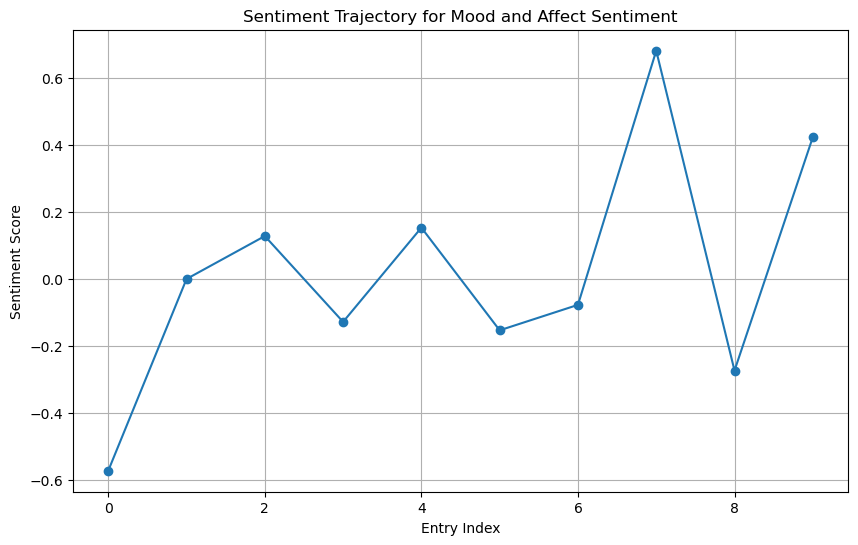

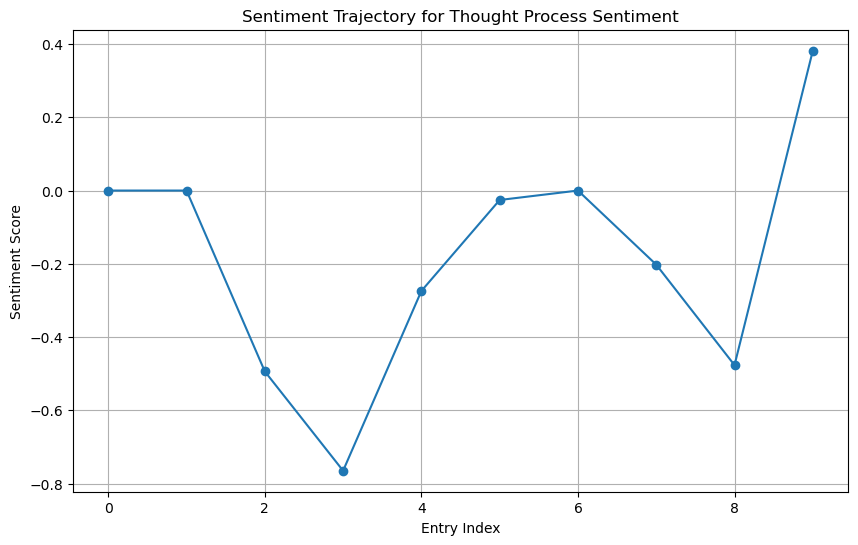

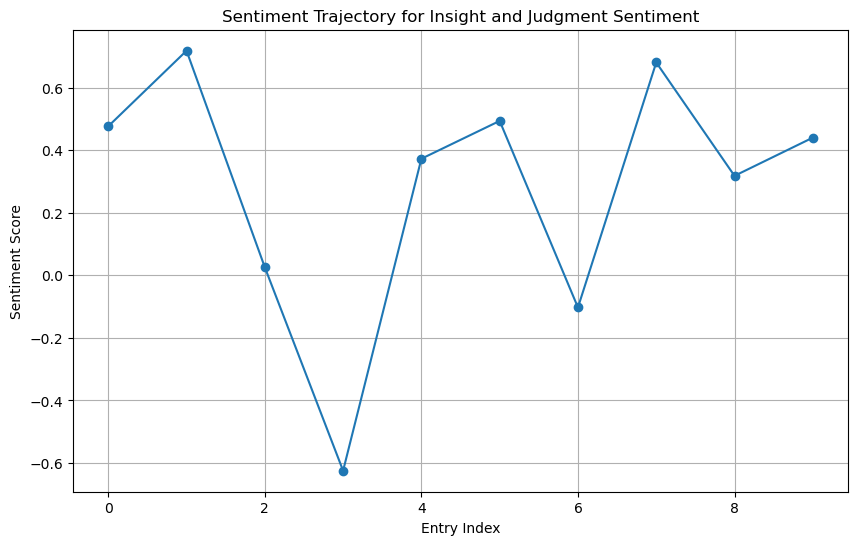

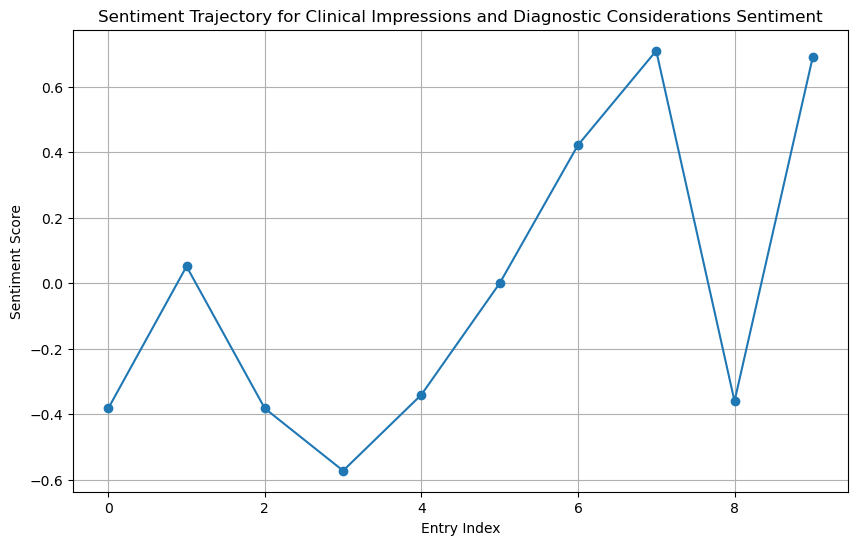

In [76]:
# Load the data
plot_data = pd.read_csv('therapy_data_sentiments.csv')

# List of columns to plot
sentiment_columns = [
    "Reason for Referral Sentiment", "Presentation Sentiment", "Speech Sentiment", 
    "Mood and Affect Sentiment", "Thought Process Sentiment", 
    "Insight and Judgment Sentiment", "Clinical Impressions and Diagnostic Considerations Sentiment"
]

# Plot each sentiment column separately
for column in sentiment_columns:
    plt.figure(figsize=(10, 6))
    plt.plot(plot_data[column], marker='o', linestyle='-')
    plt.title(f'Sentiment Trajectory for {column}')
    plt.xlabel('Entry Index')
    plt.ylabel('Sentiment Score')
    plt.grid(True)
    plt.show()